In [10]:
from deepinv.physics.generator import DiffractionBlurGenerator
from src.utils.display_utils import show_images
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transform
from product_convolution import image_to_patches, patches_to_image, product_convolution2d_patches, get_psf_product_convolution2d_patches, unity_partition_function_2d, crop_unity_partition_2d

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from torch import Tensor
import numpy as np
from typing import List, Optional, Tuple, Union
import warnings
warnings.filterwarnings("ignore", module="matplotlib\..*")

_TensorArray = Union[Tensor, np.ndarray]

def to_numpy_image(input):
    if isinstance(input, Tensor):
        if input.dim() == 3:
            return input.detach().cpu().permute(1, 2, 0).numpy()
        elif input.dim() == 4:
            return input.detach().cpu().permute(0, 2, 3, 1).numpy()

    elif isinstance(input, np.ndarray):
        print("Warning: input is already a numpy array")
        return input
    else:
        raise ValueError(f"Cannot convert {type(input)} to numpy image")
def show_images(
    imgs: Union[_TensorArray, List[_TensorArray], Tuple[_TensorArray]],
    title: List[str] = None,
    suptitle: str = None,
    ncols: int = None,
    colorbar: Optional[bool] = False,
    cmap: str = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    savename: Optional[str] = None,
    figsize: Optional[int] = 3,
    interpolation: Optional[str] = None,
):

    if isinstance(imgs, List) or isinstance(imgs, Tuple):
        if isinstance(imgs[0], np.ndarray):
            imgs = np.concatenate(imgs, axis=0)
        elif isinstance(imgs[0], torch.Tensor):
            imgs = to_numpy_image(torch.cat(imgs, dim=0))
    else:
        imgs = to_numpy_image(imgs)

    if imgs.ndim == 3:
        H, W, C = imgs.shape
        B = 1
    elif imgs.ndim == 4:
        B, H, W, C = imgs.shape

    if (ncols is not None) and (B % ncols == 0):
        nrows = B // ncols
    else:
        nrows = 1
        ncols = B
    offset = 0 if not colorbar else 0.75
    fig = plt.figure(figsize=(ncols * (figsize + offset), nrows * figsize))
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows)
    gs.update(wspace=0.025, hspace=0.025)

    if cmap is None:
        cmap = "gray" if C == 1 else None
    i = 0

    if title is None:
        title = [""]
    if len(title) != B:
        title += [""] * (B - len(title))
    with warnings.catch_warnings():
        if nrows > 1 and ncols > 1:
            for r in range(nrows):
                for c in range(ncols):
                    axs = plt.subplot(gs[r, c])
                    im = axs.imshow(
                        imgs[i],
                        vmin=vmin,
                        vmax=vmax,
                        cmap=cmap,
                        interpolation=interpolation,
                    )
                    axs.set_xticks([])
                    axs.set_yticks([])
                    if colorbar:
                        divider = make_axes_locatable(axs)
                        cax = divider.append_axes("right", size="3%", pad=0.1)
                        plt.colorbar(im, cax=cax)
                    if title:
                        axs.set_title(title[i], pad=3)

                    i += 1
        elif nrows > 1 or ncols > 1:
            for c in range(max(ncols, nrows)):
                axs = plt.subplot(gs[c])
                im = axs.imshow(
                    imgs[c], vmin=vmin, vmax=vmax, cmap=cmap, interpolation=interpolation
                )
                axs.set_xticks([])
                axs.set_yticks([])
                if colorbar:
                    divider = make_axes_locatable(axs)
                    cax = divider.append_axes("right", size="3%", pad=0.1)
                    plt.colorbar(im, cax=cax)
                if title:
                    axs.set_title(title[c], pad=3)

        else:
            axs = plt.subplot(gs[0])
            im = axs.imshow(
                imgs.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, interpolation=interpolation
            )
            axs.set_xticks([])
            axs.set_yticks([])
            if colorbar:
                divider = make_axes_locatable(axs)
                cax = divider.append_axes("right", size="3%", pad=0.1)
                plt.colorbar(im, cax=cax)
            if title:
                axs.set_title(title[0], pad=3)

        if suptitle is not None:
            fig.suptitle(suptitle, y=1.03)
        if savename is not None:
            fig.savefig(savename, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

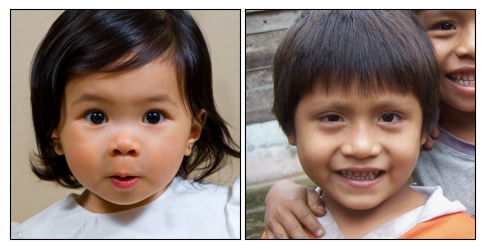

In [14]:
# %% TEST PRODUCT-CONVOLUTION
path_1 = '/home/minhhai/Works/datasets/FFHQ/images1024x1024/00003.png'
path_2 = '/home/minhhai/Works/datasets/FFHQ/images1024x1024/00014.png'

image_1 = Image.open(path_1)
image_1 = transform.ToTensor()(image_1)

image_2 = Image.open(path_2)
image_2 = transform.ToTensor()(image_2)

image = torch.stack([image_1, image_2], dim=0).cuda()
show_images(image)

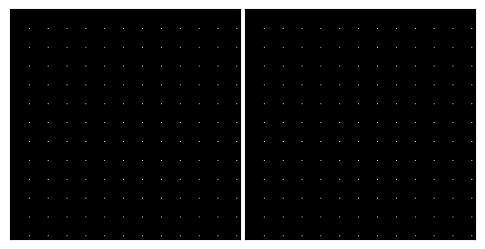

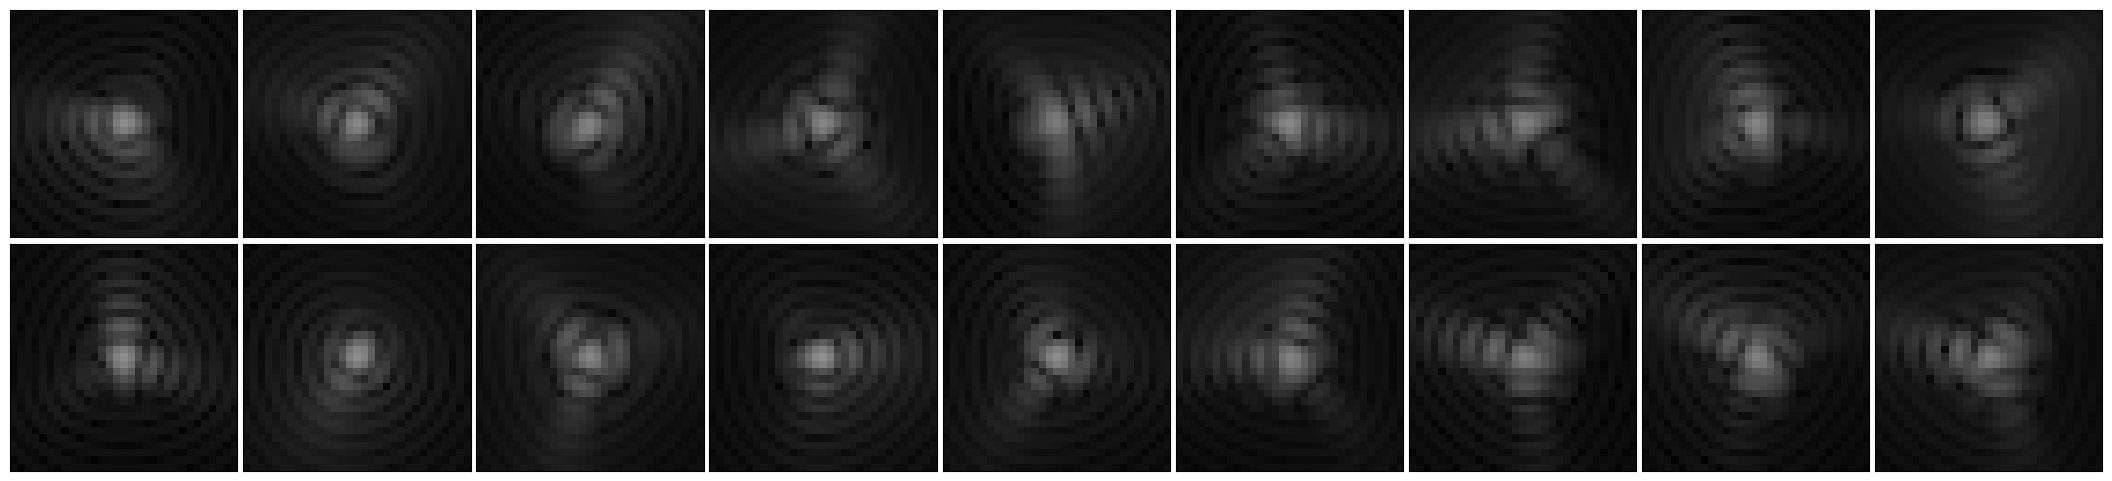

(284, 284)


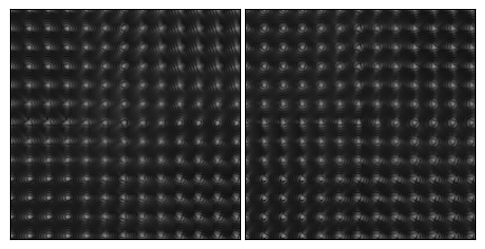

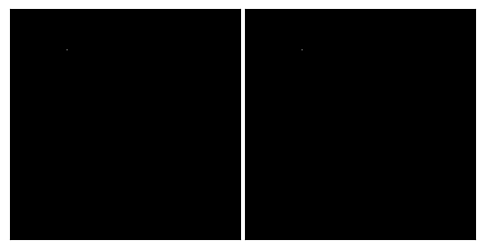

(284, 284)
n: (0, 0)
patch_position_h [45]
patch_position_w [63]
index:  [0] [0]


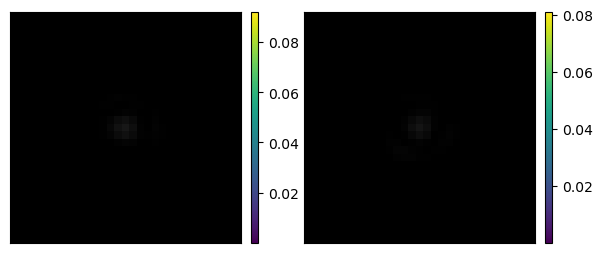

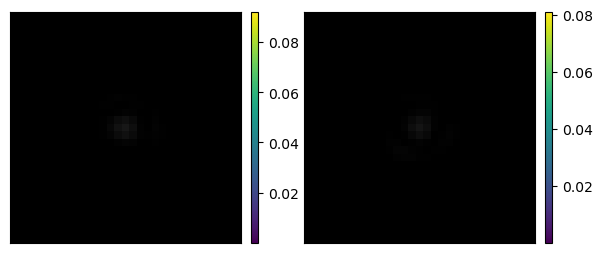

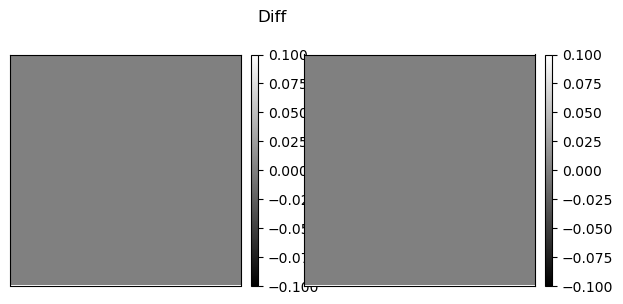

tensor(0., device='cuda:0')

In [16]:
# %%
image = torch.zeros(2, 3, 256, 256, device='cuda')
image[..., ::21, ::21] = 1.
show_images(image)

# %%
# image = torch.randn(1, 3, 256, 256).cuda()

psf_size = (31, 31)
patch_size = (128, 128)
overlap = (64, 64)
patches = image_to_patches(image, patch_size, overlap)
K = patches.size(2) * patches.size(3)


generator = DiffractionBlurGenerator(
    psf_size, num_channels=3, fc=0.2, device='cuda')
h = torch.stack([generator.step(image.size(0))['filter']
                 for _ in range(K)], dim=0)
masks = unity_partition_function_2d(image.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.unsqueeze(1).unsqueeze(2).cuda()

show_images(h.flatten(0, 1) ** 0.25, ncols=K)
blurry = product_convolution2d_patches(image, w, h, patch_size, overlap)
show_images(blurry ** 0.25)

# %%
position = (45, 63)
psf_size = (31, 31)
patch_size = (128, 128)
overlap = (64, 64)

image = torch.zeros(2, 3, 256, 256, device='cuda')
image[..., position[0]: position[0] + 1, position[1]: position[1] + 1] = 1.
show_images(image)

masks = unity_partition_function_2d(image.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.unsqueeze(1).unsqueeze(2).cuda()
w = torch.ones_like(w)

blurry = product_convolution2d_patches(image, w, h, patch_size, overlap)


patches = image_to_patches(image, patch_size, overlap)
psf = get_psf_product_convolution2d_patches(
    h, w, position, overlap, patches.shape[2:4])


show_images(blurry[..., position[0] - psf_size[0] // 2: position[0] + psf_size[0] //
            2 + 1, position[1] - psf_size[1] // 2: position[1] + psf_size[1] // 2 + 1] ** 1, colorbar=True)
show_images(psf ** 1, colorbar=True)

show_images((blurry[:, 0:1, position[0] - psf_size[0] // 2: position[0] + psf_size[0] //
                    2 + 1, position[1] - psf_size[1] // 2: position[1] + psf_size[1] // 2 + 1] - psf[:, 0:1, ...]),
            suptitle='Diff',
            colorbar=True)
torch.norm(blurry[..., position[0] - psf_size[0] // 2: position[0] + psf_size[0] //
                  2 + 1, position[1] - psf_size[1] // 2: position[1] + psf_size[1] // 2 + 1] - psf)